In [26]:
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import*
from scipy.io import wavfile
import os
import librosa.display
import pandas as pd
import librosa
import glob 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from sklearn.utils import shuffle
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import scipy
import speech_recognition as sr
import spacy
import en_core_web_sm
import audioread
import pickle

# Acoustic Model

# Acoustic Feature Extraction


In [30]:
label=[]
melFeatures=[]
def getTrainingFeaturesS(directory):
    for x in os.listdir(directory):
        data, sampling_rate = librosa.load(directory+x)
        mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T,axis=0)
        label.append(1)
        melFeatures.append([x for x in mel])
def getTrainingFeaturesNS(directory):
    for x in os.listdir(directory):
        data, sampling_rate = librosa.load(directory+x)
        mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T,axis=0)
        label.append(0)
        melFeatures.append([x for x in mel])    


In [31]:
getTrainingFeaturesS('/Users/salmafikry/Desktop/UNI/Disso/Intense/')
#getTrainingFeaturesS('/Users/salmafikry/Desktop/OAF_Fear/')
#getTrainingFeaturesNS('/Users/salmafikry/Desktop/OAF_neutral/')
getTrainingFeaturesNS('/Users/salmafikry/Desktop/UNI/Disso/Neutral/')
melFeaturesdf=pd.DataFrame(melFeatures)
x= np.asarray(melFeaturesdf)
y= np.asarray(label)

# Acoustic Model Building

In [32]:
epochs=20
learning_rate = 0.22
decay_rate = learning_rate / epochs
#decay_rate=0.08
momentum = 0.7

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 127)
input_dim = x_train.shape[1]

lr_model = Sequential()
#input layer
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim)) 
#dropout layer
lr_model.add(Dropout(0.1))
#hidden layer
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
#output layer
lr_model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# compile the model

lr_model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['acc'])
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(224, 128) (224,)
(56, 128) (56,)


In [33]:
%%time
#Fit the model
# you invoke the LearningRateScheduler during the .fit() phase

lr_model_history = lr_model.fit(x_train, y_train,epochs=epochs,verbose=1,validation_data=(x_test, y_test))

Train on 224 samples, validate on 56 samples
Epoch 1/20
224/224 [==============================] - 0s 618us/step - loss: 0.6643 - acc: 0.6161 - val_loss: 0.6349 - val_acc: 0.4643
Epoch 2/20
224/224 [==============================] - 0s 48us/step - loss: 0.5440 - acc: 0.5982 - val_loss: 0.5700 - val_acc: 0.4643
Epoch 3/20
224/224 [==============================] - 0s 37us/step - loss: 0.4626 - acc: 0.7143 - val_loss: 0.5108 - val_acc: 0.7679
Epoch 4/20
224/224 [==============================] - 0s 52us/step - loss: 0.4056 - acc: 0.8438 - val_loss: 0.4796 - val_acc: 0.7679
Epoch 5/20
224/224 [==============================] - 0s 49us/step - loss: 0.3750 - acc: 0.8438 - val_loss: 0.4622 - val_acc: 0.7679
Epoch 6/20
224/224 [==============================] - 0s 39us/step - loss: 0.3527 - acc: 0.8571 - val_loss: 0.4434 - val_acc: 0.7679
Epoch 7/20
224/224 [==============================] - 0s 46us/step - loss: 0.3417 - acc: 0.8527 - val_loss: 0.4249 - val_acc: 0.7857
Epoch 8/20
224/224 [===

# Acoustic Model Evaluation

In [34]:
(loss, accuracy) = lr_model.evaluate(x_test, y_test, batch_size=1, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

56/56 [==============================] - 0s 425us/step
[INFO] loss=0.3726, accuracy: 82.1429%


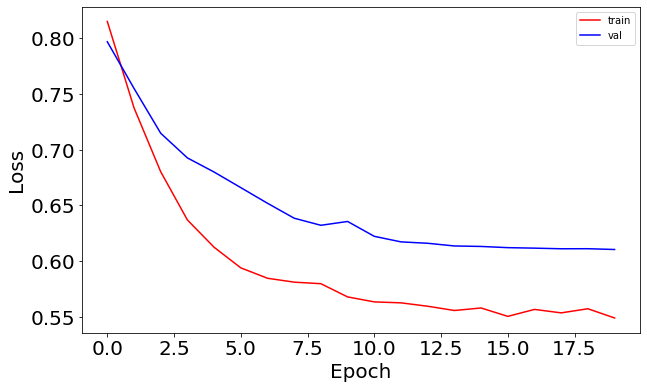

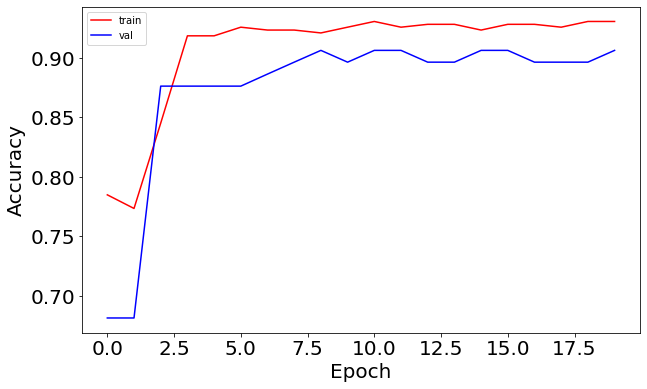

In [35]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [36]:
y_pred = lr_model.predict(x_test)
ypred=[]
for y in y_pred:
    ypred.append(round(y[0]))

In [37]:
score = f1_score(ypred, y_test)
score

0.7727272727272727

# Save Model

In [38]:
import pickle
#serialize your python object into a file
with open('acousticModel', 'wb') as f:
    pickle.dump(lr_model,f)

# Test Acoustic Models

In [39]:
def testAcoustic(audio,model):
    melfeat=[]
    data, sampling_rate=librosa.load(audio)
    mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T,axis=0)
    melfeat.append([x for x in mel])
    melfeat=pd.DataFrame(melfeat)
    yhat=model.predict(np.asarray(melfeat))
    return round(yhat[0,0])

## Load Model Pickle
### Loads the model that uses RAVDESS dataset only

In [40]:
with open('acousticModel', 'rb') as f:
    acousticmodel=pickle.load(f)

Test a sample audio file

In [41]:
if testAcoustic('/Users/salmafikry/Desktop/UNI/Disso/YAF_limb_neutral.wav', acousticmodel)==1.0:
    print("Anger or Fear Emotions Detected")
else:
    print("Neither anger nor fear emotions are detected")

/Users/salmafikry/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/salmafikry/Desktop/UNI/Disso/YAF_limb_neutral.wav'

### Loads the model that uses both RAVDESS and TESS datasets

In [42]:
with open('acousticModelBoth', 'rb') as f:
    acousticBoth=pickle.load(f)

Test a sample audio file

In [8]:
if testAcoustic('/Users/salmafikry/Desktop/YAF_limb_neutral.wav', acousticBoth)==1.0:
    print("Anger or Fear Emotions Detected")
else:
    print("Neither anger nor fear emotions are detected")

Neither anger nor fear emotions are detected


# Grid Optimization

In [1196]:
input_dim = x_train.shape[1]
num_classes = 2


# a function that created the model with default values: optimizer= 'rmsprop'
# and init='glorot_niform'
def create_model_2(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init, activation=tf.nn.relu))
    model.add(Dense(num_classes, kernel_initializer=init, activation=tf.nn.softmax))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [1189]:
%%time


# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model_2, verbose=1)

# define initializer options
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

batches = [1,15]
epochs = [10, 20]
learningrates=[0.08, 0.1, 0.12,0.5, 0.2, 0.17]

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid,cv=3)
grid_result = grid.fit(x_train, y_train)

Epoch 1/10
149/149 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.6443
Epoch 2/10
149/149 [==============================] - 0s 766us/step - loss: 0.4125 - accuracy: 0.8389
Epoch 3/10
149/149 [==============================] - 0s 671us/step - loss: 0.3916 - accuracy: 0.8456
Epoch 4/10
149/149 [==============================] - 0s 661us/step - loss: 0.3616 - accuracy: 0.8523
Epoch 5/10
149/149 [==============================] - 0s 693us/step - loss: 0.3549 - accuracy: 0.8456
Epoch 6/10
149/149 [==============================] - 0s 720us/step - loss: 0.3236 - accuracy: 0.8591
Epoch 7/10
149/149 [==============================] - 0s 736us/step - loss: 0.3639 - accuracy: 0.8725
Epoch 8/10
149/149 [==============================] - 0s 738us/step - loss: 0.3387 - accuracy: 0.8658
Epoch 9/10
149/149 [==============================] - 0s 765us/step - loss: 0.3276 - accuracy: 0.8523
Epoch 10/10
75/75 [==============================] - 0s 843us/step
Epoch 1/10
149/14

/Users/salmafikry/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/10
224/224 [==============================] - 0s 449us/step - loss: 0.5896 - accuracy: 0.5714
Epoch 2/10
224/224 [==============================] - 0s 78us/step - loss: 0.4864 - accuracy: 0.6607
Epoch 3/10
224/224 [==============================] - 0s 76us/step - loss: 0.4517 - accuracy: 0.7902
Epoch 4/10
224/224 [==============================] - 0s 74us/step - loss: 0.4300 - accuracy: 0.8616
Epoch 5/10
224/224 [==============================] - 0s 73us/step - loss: 0.4152 - accuracy: 0.8571
Epoch 6/10
224/224 [==============================] - 0s 68us/step - loss: 0.4010 - accuracy: 0.8661
Epoch 7/10
224/224 [==============================] - 0s 68us/step - loss: 0.3931 - accuracy: 0.8661
Epoch 8/10
224/224 [==============================] - 0s 63us/step - loss: 0.3836 - accuracy: 0.8661
Epoch 9/10
224/224 [==============================] - 0s 57us/step - loss: 0.3724 - accuracy: 0.8661
Epoch 10/10
224/224 [==============================] - 0s 59us/step - loss: 0.3628 - accur

In [1191]:
# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8661 using {'batch_size': 15, 'epochs': 10, 'init': 'normal'}
mean=0.8616, std=0.01756 using {'batch_size': 1, 'epochs': 10, 'init': 'uniform'}
mean=0.8527, std=0.02271 using {'batch_size': 1, 'epochs': 10, 'init': 'lecun_uniform'}
mean=0.8571, std=0.0174 using {'batch_size': 1, 'epochs': 10, 'init': 'normal'}
mean=0.5982, std=0.05255 using {'batch_size': 1, 'epochs': 10, 'init': 'zero'}
mean=0.8571, std=0.0174 using {'batch_size': 1, 'epochs': 10, 'init': 'glorot_normal'}
mean=0.8571, std=0.02569 using {'batch_size': 1, 'epochs': 10, 'init': 'glorot_uniform'}
mean=0.8571, std=0.01686 using {'batch_size': 1, 'epochs': 10, 'init': 'he_normal'}
mean=0.8571, std=0.02369 using {'batch_size': 1, 'epochs': 10, 'init': 'he_uniform'}
mean=0.8571, std=0.01356 using {'batch_size': 1, 'epochs': 20, 'init': 'uniform'}
mean=0.8527, std=0.02271 using {'batch_size': 1, 'epochs': 20, 'init': 'lecun_uniform'}
mean=0.8437, std=0.02834 using {'batch_size': 1, 'epochs': 20, 'init': 'no

In [1198]:
le = LabelEncoder()
#label based on 0s and 1s
yy = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, yy, test_size=0.2, random_state = 127)
gridmodel = Sequential()
gridmodel.add(Dense(64, input_dim=input_dim, kernel_initializer='lecun_uniform', activation='relu'))
gridmodel.add(Dropout(0.1))
gridmodel.add(Dense(64, kernel_initializer='lecun_uniform', activation=tf.nn.relu))
gridmodel.add(Dense(num_classes, kernel_initializer='lecun_uniform', activation=tf.nn.softmax))
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# compile model
gridmodel.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'], )
gridmodel.fit(x_train, y_train,batch_size=1,epochs=20, verbose=1,validation_data=(x_test, y_test))

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 1s 872us/step - loss: 9166.9269 - accuracy: 0.5456 - val_loss: 0.6553 - val_accuracy: 0.5729
Epoch 2/20
768/768 [==============================] - 1s 704us/step - loss: 0.6820 - accuracy: 0.4909 - val_loss: 0.6550 - val_accuracy: 0.5729
Epoch 3/20
768/768 [==============================] - 1s 671us/step - loss: 0.6189 - accuracy: 0.6328 - val_loss: 0.4389 - val_accuracy: 0.7604
Epoch 4/20
768/768 [==============================] - 1s 696us/step - loss: 0.4570 - accuracy: 0.7565 - val_loss: 0.3848 - val_accuracy: 0.8021
Epoch 5/20
768/768 [==============================] - 1s 679us/step - loss: 23817.2086 - accuracy: 0.5573 - val_loss: 0.5131 - val_accuracy: 0.7083
Epoch 6/20
768/768 [==============================] - 1s 692us/step - loss: 0.4627 - accuracy: 0.7474 - val_loss: 0.3715 - val_accuracy: 0.8125
Epoch 7/20
768/768 [==============================] - 1s 742us/step - loss: 0.4173 

In [1199]:
(loss, accuracy) = gridmodel.evaluate(x_test, y_test, batch_size=1, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

192/192 [==============================] - 0s 386us/step
[INFO] loss=0.2332, accuracy: 91.1458%


In [1200]:
#serialize your python object into a file
with open('acousticGridModel', 'wb') as f:
    pickle.dump(gridmodel,f)

# Lexical Model

In [1]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salmafikry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salmafikry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salmafikry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


In [2]:

def preProcess(sentence):
    tokens= sentence.split()
    stop_words = set(stopwords.words('english'))
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        tokens = np.char.replace(tokens, i, ' ')
    
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [3]:
def getVocab(directory, directory2):
    vocab=Counter()
    for sent in directory:
        tokens=preProcess(sent)
        vocab.update(tokens)
    for sent in directory2:
        tokens=preProcess(sent)
        vocab.update(tokens)
    vocab = [k for k,c in vocab.items() if c >= 2]
    return vocab

In [4]:
def getLinesTraining(directory,directoryn,vocab):
    lines=list()
    labels=[]
    for sent in directory:
        tokens=preProcess(sent)
        tokens = [w for w in tokens if w in vocab]
        lines.append(' '.join(tokens))
        #1 for anger or fear
        labels.append(1)
    for sent in directoryn:
        tokens=preProcess(sent)
        tokens = [w for w in tokens if w in vocab]
        lines.append(' '.join(tokens))
        #0 for neutral
        labels.append(0)
    return lines, labels

In [9]:
dfexcel = pd.read_excel(r'/Users/salmafikry/Desktop/DissoCode/train.xls')
dfexcelnot= pd.read_excel(r'/Users/salmafikry/Desktop/DissoCode/notanger.xls')
dfexceltest = pd.read_excel(r'/Users/salmafikry/Desktop/DissoCode/test.xls')
dfexceltestfear = pd.read_excel(r'/Users/salmafikry/Desktop/DissoCode/testfear.xls')
vocab=getVocab(dfexcel.Sentence, dfexcelnot.Sentence)

dfexcelll = pd.read_excel(r'/Users/salmafikry/Desktop/UNI/Disso/emotionintensity.xls')
wordsvocab=[]
i=0
while i<len(dfexcelll):
    wordsvocab.append(dfexcelll['word'][i])
    i=i+1  
    
aggvocab=wordsvocab+vocab
lines, labels= getLinesTraining(dfexcel.Sentence,dfexcelnot.Sentence, vocab)



### Save the Vocab

In [10]:
data = '\n'.join(vocab)
# open file
file = open('vocabdict.txt', 'w')
# write text
file.write(data)
# close file
file.close()

In [11]:
from array import array
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer
tokenizer.fit_on_texts(lines)
# encode training data set
Xtrain = tokenizer.texts_to_matrix(lines, mode='binary')
ytrain = np.asarray(labels)

In [12]:
lines1, labels1= getLinesTraining(dfexceltestfear.Sentence,dfexceltest.Sentence, vocab)

In [13]:
# encode training data set
Xtest = tokenizer.texts_to_matrix(lines1, mode='binary')
ytest = np.asarray(labels1)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
n_words = Xtest.shape[1]
# define network
linearmodel = Sequential()
linearmodel.add(Dense(50, input_shape=(n_words,), activation='relu'))
linearmodel.add(Dense(1, activation='sigmoid'))
# compile network
linearmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
linearmodel.fit(Xtrain, ytrain, epochs=50, verbose=2)
# evaluate
loss, acc = linearmodel.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/50
 - 0s - loss: 0.6403 - accuracy: 0.7259
Epoch 2/50
 - 0s - loss: 0.3570 - accuracy: 0.9310
Epoch 3/50
 - 0s - loss: 0.1719 - accuracy: 0.9656
Epoch 4/50
 - 0s - loss: 0.1015 - accuracy: 0.9777
Epoch 5/50
 - 0s - loss: 0.0695 - accuracy: 0.9869
Epoch 6/50
 - 0s - loss: 0.0511 - accuracy: 0.9912
Epoch 7/50
 - 0s - loss: 0.0397 - accuracy: 0.9920
Epoch 8/50
 - 0s - loss: 0.0316 - accuracy: 0.9942
Epoch 9/50
 - 0s - loss: 0.0262 - accuracy: 0.9945
Epoch 10/50
 - 0s - loss: 0.0224 - accuracy: 0.9947
Epoch 11/50
 - 0s - loss: 0.0193 - accuracy: 0.9955
Epoch 12/50
 - 0s - loss: 0.0165 - accuracy: 0.9967
Epoch 13/50
 - 0s - loss: 0.0146 - accuracy: 0.9970
Epoch 14/50
 - 0s - loss: 0.0130 - accuracy: 0.9965
Epoch 15/50
 - 0s - loss: 0.0118 - accuracy: 0.9975
Epoch 16/50
 - 0s - loss: 0.0109 - accuracy: 0.9975
Epoch 17/50
 - 0s - loss: 0.0098 - accuracy: 0.9975
Epoch 18/50
 - 0s - loss: 0.0090 - accuracy: 0.9977
Epoch 19/50
 - 0s - loss: 0.0084 - accuracy: 0.9975
Epoch 20/50
 - 0s - l

In [15]:
y_pred = linearmodel.predict(Xtest)
ypred=[]
for y in y_pred:
    ypred.append(round(y[0]))

In [16]:
from sklearn.metrics import f1_score
score = f1_score(ypred, ytest)

In [17]:
score

0.7795698924731181

# Test Lexical Model
## Save Model

In [18]:
#serialize your python object into a file
with open('lexicalModelNew', 'wb') as f:
    pickle.dump(linearmodel,f)

## Test

In [19]:
def testLexical(audio,model):
    r= sr.Recognizer()
    with sr.WavFile(audio) as source:
        audio = r.record(source) 
    try:
        sentence= r.recognize_google(audio) 
    except LookupError:                                
        print("Could not understand audio") 
    tokens= preProcess(sentence)
    #load the vocab
    file = open('vocabdict.txt', 'r')
    # read all text
    vocab = file.read()
    # close the file
    file.close()
    vocab = vocab.split()
    vocab = set(vocab)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    featurestext = tokenizer.texts_to_matrix([line], mode='binary')
    yhat = model.predict(featurestext, verbose=0)
    return round(yhat[0,0])

## Load Lexical Model

In [20]:
with open('lexicalModelNew', 'rb') as f:
    lexmodel=pickle.load(f)

In [22]:
if testLexical('/Users/salmafikry/Desktop/UNI/Disso/generatedTests/testAudioAngryL.wav', lexmodel)==1:
    print("Anger or Fear Emotions Detected")
else:
    print("Neither anger nor fear emotions are detected") 

Anger or Fear Emotions Detected


# Joint Predictions

## OR Function

In [23]:
def getFinalPrediction(audio):
    
    if testAcoustic(audio,acousticBoth)==1.0 or testLexical(audio,lexmodel)==1:
        print("Anger or Fear Emotions Detected")
        x=1
    else:
        print("Neither anger nor fear emotions are detected")
        x=0
    return x
    

In [25]:
#neutral 
getFinalPrediction('/Users/salmafikry/Desktop/UNI/Disso/genNeutral/testAudioNeutral.wav')

NameError: name 'testAcoustic' is not defined

In [ ]:
#fear
getFinalPrediction('/Users/salmafikry/Desktop/generatedTests/fear.wav')

In [55]:
#angry
getFinalPrediction('/Users/salmafikry/Desktop/generatedTests/testAudioAngry.wav')

Anger or Fear Emotions Detected


1

In [ ]:
#testing acoustic model on its own on an angry audio
testAcoustic('/Users/salmafikry/Desktop/generatedTests/testAudioAngry.wav', acousticBoth)

In [ ]:
#testing lexical model on its own on an angry audio
testLexical('/Users/salmafikry/Desktop/generatedTests/testAudioAngry.wav', lexmodel)

In [57]:
#testing acoustic model on its own on an angry audio, but the acoustic model did not detect it
testAcoustic('/Users/salmafikry/Desktop/generatedTests/testAudioAngryL.wav', acousticBoth)

0.0

In [58]:
#testing lexical model on its own on on the same angry audio
testLexical('/Users/salmafikry/Desktop/generatedTests/testAudioAngryL.wav', lexmodel)

1.0

In [59]:
#the final model on the angry audio (lexical model only detected it correctly)
getFinalPrediction('/Users/salmafikry/Desktop/generatedTests/testAudioAngryL.wav')

Anger or Fear Emotions Detected


1

In [ ]:
directory=('/Users/salmafikry/Desktop/generatedTests/')
predictions=[]
for y in os.listdir(directory):
    x=getFinalPrediction(directory+y)
    predictions.append(x)
directory1=('/Users/salmafikry/Desktop/genNeutral/')
for y in os.listdir(directory1):
    x=getFinalPrediction(directory1+y)
    predictions.append(x)

In [53]:
directory=('/Users/salmafikry/Desktop/generatedTests/')
predictions=[]
for y in os.listdir(directory):
    x=getFinalPrediction(directory+y)
    predictions.append(x)
directory1=('/Users/salmafikry/Desktop/genNeutral/')
for y in os.listdir(directory1):
    x=getFinalPrediction(directory1+y)
    predictions.append(x)


Anger or Fear Emotions Detected
Anger or Fear Emotions Detected
Anger or Fear Emotions Detected
Neither anger nor fear emotions are detected
Anger or Fear Emotions Detected
Anger or Fear Emotions Detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected


## AND Function

In [ ]:
def getFinalPredictionAnd(audio):
    
    if testAcoustic(audio,acousticBoth)==1.0 and testLexical(audio,lexmodel)==1:
        print("Anger or Fear Emotions Detected")
        x=1
    else:
        print("Neither anger nor fear emotions are detected")
        x=0
    return x
    

In [1184]:
directory=('/Users/salmafikry/Desktop/generatedTests/')
predictions=[]
for y in os.listdir(directory):
    x=getFinalPredictionAnd(directory+y)
    predictions.append(x)
directory1=('/Users/salmafikry/Desktop/genNeutral/')
for y in os.listdir(directory1):
    x=getFinalPredictionAnd(directory1+y)
    predictions.append(x)

Neither anger nor fear emotions are detected
Anger or Fear Emotions Detected
Anger or Fear Emotions Detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
Neither anger nor fear emotions are detected
